In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

import pickle
import json
import numpy as np
import matplotlib as mpl

In [60]:
mpl.style.use('seaborn-v0_8-colorblind')
plt.rcParams["font.family"] = "serif"

### 3.1 Experiments

In [61]:
models = ["hyperprior", "mbt2018", "cheng2020-attn", "qres17m", "qarv"]
races = ['Indian', 'Asian', 'African', 'Caucasian']
qualities = ["q_0001", "q_0009", "q_1", "q_2", "q_3"]
categories = ['skin_type', 'eye_type', 'nose_type', 'lip_type', 'hair_type', 'hair_color']
category_names = ['Skin Type', 'Eye Type', 'Nose Type', 'Lip Type', 'Hair Type', 'Hair Color']
qres = ["1", "3", "6", "9", "12"]
qarv = ["lmb_1", "lmb_4", "lmb_8", "lmb_16", "lmb_32" ]
markers = ['s', 'o', '^', '*', 'D']
linestyles = ['solid', 'dashed', 'dashdot', 'dotted', "dotted"]

In [62]:
## for a model and generate accuracies for all rates
def generate_results(dataset="celebA", model="hyperprior"):
    rates = []
    results = {}
    for i, q in enumerate(qualities):
        results[q] = {}
        #Iterate through qualities and pull dictionaries
        with open(f'/media/global_data/fair_neural_compression_data/predictions/{model}/{dataset}/{q}/sep_predictions.pkl', 'rb') as f:
            all_predictions = pickle.load(f)
        with open(f'/media/global_data/fair_neural_compression_data/predictions/hyperprior/celebA/clean/sep_labels.pkl', 'rb') as f:
            all_labels = pickle.load(f)
        
        if model == "qarv":
            with open(f'/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/qarv/celebA/{qarv[i]}/stats.json', 'r') as json_file:
                        data_dict = json.load(json_file)
            bpp = data_dict['results']['bpp']
            pass
        elif model == "qres17m":
            with open(f'/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/qres17m_lmb_64/celebA/{qres[i]}/stats.json', 'r') as json_file:
                        data_dict = json.load(json_file)
            bpp = data_dict['results']['bpp']
        else:
            with open(f'/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/{model}/{dataset}/{q}/stats.json', 'r') as json_file:
                        data_dict = json.load(json_file)
            bpp = data_dict['est_bpp']
        rates.append(bpp)
        for race in races:
            results[q][race] = {}
            for cat in categories:
                pred = all_predictions[race][cat]
                labels = all_labels[race][cat]
                score = accuracy_score(pred, labels)
                results[q][race][cat] = score
                
        
    temp = {}
    for cat in categories:
        temp[cat] = {}
        for race in races:
            temp[cat][race] = [results[q][race][cat] for q in qualities]
    return temp, rates

In [63]:
with open(f'/media/global_data/fair_neural_compression_data/predictions/hyperprior/celebA/clean/sep_labels.pkl', 'rb') as f:
     pred_dict = pickle.load(f)

In [64]:
counts = []
for race in races:
    counts.append(len(pred_dict[race]["eye_type"]))
counts

[1041, 941, 1091, 988]

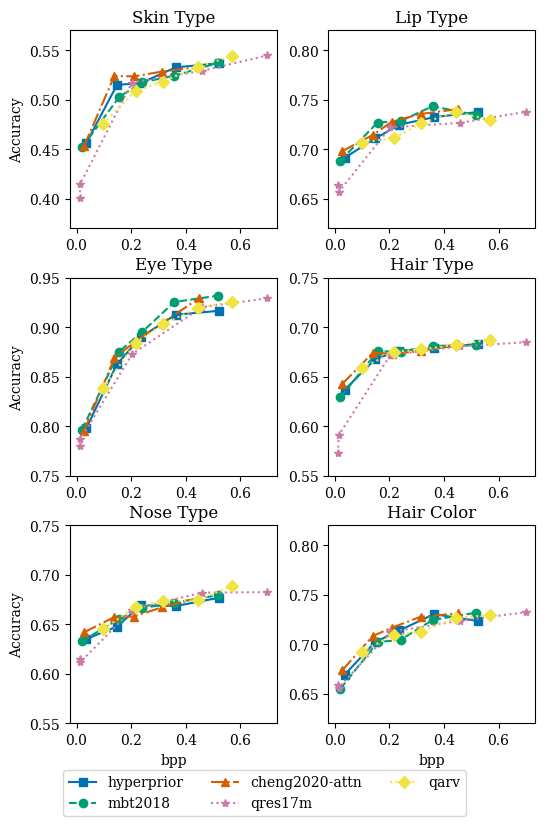

In [65]:
dataset = "celebA"
fig, axes = plt.subplots(len(categories)//2, 2, figsize=(6, 9))


## Get rates
for z, model in enumerate(models):
    temp, rates = generate_results(model=model)
    for i, cat in enumerate(categories):
        accs = []
        axes[i%3][i//3].set_title(category_names[i])
        for j, q in enumerate(qualities):
            yurg = []
            for race in races:
                yurg.append(temp[cat][race][j])
           
            accs.append(np.average(yurg, weights=counts))
        axes[i%3][i//3].plot(rates, accs, label = model, linestyle = linestyles[z], marker = markers[z])
        axes[2][i//3].set_xlabel("bpp")
        axes[i%3][0].set_ylabel("Accuracy")
        
axes[2][1].legend(bbox_to_anchor=(0.7, -0.2), ncol = 3)

fig.subplots_adjust(hspace=0.25, wspace=0.25)

axes[0][0].set_ylim(0.37, 0.57)
axes[0][1].set_ylim(0.62, 0.82)


axes[1][0].set_ylim(0.75, 0.95)
axes[1][1].set_ylim(0.55, 0.75)

axes[2][0].set_ylim(0.55, 0.75)
axes[2][1].set_ylim(0.62, 0.82)

plt.show()

    
    
    ## Weighted average across races


### 3.2 Experiments

In [66]:
races = ['Indian', 'Asian', 'African', 'Caucasian']
categories = ['skin_type', 'eye_type', 'nose_type', 'lip_type', 'hair_type', 'hair_color']
lambda_file_names = ["1"]
lambda_values = [1]
data_rate_values = ["clean"]
qualities = ["q_0001", "q_0009", "q_1", "q_2", "q_3"]
qres = ["1", "3", "6", "9", "12"]
rates = []
race_markers = ['s', 'o', '^', '*']

In [103]:
## for a model and generate accuracies for all rates
def generate_results(dataset="celebA", model="hyperprior"):
    rates = []
    results = {}
    for i, q in enumerate(qualities):
        results[q] = {}
        #Iterate through qualities and pull dictionaries
        with open(f'/media/global_data/fair_neural_compression_data/predictions/{model}/{dataset}/{q}/sep_predictions.pkl', 'rb') as f:
            all_predictions = pickle.load(f)
        with open(f'/media/global_data/fair_neural_compression_data/predictions/hyperprior/celebA/clean/sep_labels.pkl', 'rb') as f:
            all_labels = pickle.load(f)

        if model == "qarv":
            with open(f'/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/qarv/celebA/{qarv[i]}/stats.json', 'r') as json_file:
                        data_dict = json.load(json_file)
            bpp = data_dict['results']['bpp']

        elif model == "qres17m":
            with open(f'/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/qres17m_lmb_64/celebA/{qres[i]}/stats.json', 'r') as json_file:
                        data_dict = json.load(json_file)
            bpp = data_dict['results']['bpp']
        else:
            with open(f'/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/{model}/{dataset}/{q}/stats.json', 'r') as json_file:
                        data_dict = json.load(json_file)
            bpp = data_dict['est_bpp']
        rates.append(bpp)
        for race in races:
            results[q][race] = {}
            for cat in categories:
                pred = all_predictions[race][cat]
                labels = all_labels[race][cat]
                score = accuracy_score(pred, labels)
                results[q][race][cat] = score
                print(q, race, cat)
                print(confusion_matrix(labels, pred))
        
    temp = {}
    for cat in categories:
        temp[cat] = {}
        for race in races:
            temp[cat][race] = [results[q][race][cat] for q in qualities]
    return temp, rates

In [104]:
def get_clean_pred(dataset="celebA", model="hyperprior"):
    with open(f'/media/global_data/fair_neural_compression_data/predictions/{model}/{dataset}/clean/sep_predictions.pkl', 'rb') as f:
                all_predictions = pickle.load(f)
    with open(f'/media/global_data/fair_neural_compression_data/predictions/hyperprior/celebA/clean/sep_labels.pkl', 'rb') as f:
                all_labels = pickle.load(f)
    results = {}
    for race in races:
            results[race] = {}
            for cat in categories:
                pred = all_predictions[race][cat]
                labels = all_labels[race][cat]
                results[race][cat] = accuracy_score(pred, labels)
    return results

In [105]:
model = "hyperprior"

temp, rates = generate_results(model=model)
ff_temp, ff_rates = generate_results("fairface", model=model)
results = get_clean_pred()
ff_results = get_clean_pred()

q_0001 Indian skin_type
[[  3   9   0   8]
 [ 73 343   0 323]
 [  0   4   0   8]
 [  7  94   0 169]]
q_0001 Indian eye_type
[[942  95]
 [  4   0]]
q_0001 Indian nose_type
[[455 167]
 [225 194]]
q_0001 Indian lip_type
[[ 94 377]
 [ 81 489]]
q_0001 Indian hair_type
[[  4   0   0  29]
 [ 21   0   0 254]
 [ 15   0   0  75]
 [ 53   0   0 590]]
q_0001 Indian hair_color
[[612  21  42   3   0]
 [107  65   5   8   0]
 [149   5  17   2   0]
 [  1   0   0   0   0]
 [  4   0   0   0   0]]
q_0001 Asian skin_type
[[  1   1   0   1]
 [ 28 115   0 212]
 [  2   2   0  43]
 [ 30 106   0 400]]
q_0001 Asian eye_type
[[ 43  14]
 [584 300]]
q_0001 Asian nose_type
[[234 193]
 [237 277]]
q_0001 Asian lip_type
[[ 21 179]
 [ 73 668]]
q_0001 Asian hair_type
[[  0   0   0   2]
 [  7   0   0 106]
 [  2   0   0  44]
 [ 49   0   0 731]]
q_0001 Asian hair_color
[[590  12  51  10   0]
 [ 37  18   3   1   0]
 [149   1  38   0   0]
 [ 13   1   4   2   0]
 [  6   0   3   2   0]]
q_0001 African skin_type
[[  0 395  42  17

In [70]:
mpl.style.use('seaborn-v0_8-colorblind')
#plt.rcParams["font.family"] = "lucida-console"

In [91]:
print(results)

{'Indian': {'skin_type': 0.6464937560038425, 'eye_type': 0.9779058597502401, 'nose_type': 0.6522574447646494, 'lip_type': 0.633045148895293, 'hair_type': 0.6340057636887608, 'hair_color': 0.7022094140249759}, 'Asian': {'skin_type': 0.6323060573857598, 'eye_type': 0.8501594048884166, 'nose_type': 0.6153028692879915, 'lip_type': 0.7736450584484591, 'hair_type': 0.8129649309245484, 'hair_color': 0.7268862911795961}, 'African': {'skin_type': 0.5022914757103575, 'eye_type': 0.9798350137488543, 'nose_type': 0.8194317140238313, 'lip_type': 0.7836846929422548, 'hair_type': 0.7396883593033914, 'hair_color': 0.9450045829514208}, 'Caucasian': {'skin_type': 0.4331983805668016, 'eye_type': 0.9564777327935222, 'nose_type': 0.6467611336032388, 'lip_type': 0.8562753036437247, 'hair_type': 0.6427125506072875, 'hair_color': 0.5607287449392713}}


In [101]:
def plot_races_and_fairness(temp, rates, results):
    fig, axes = plt.subplots(len(categories)//2, 2, figsize=(6, 9), sharey=True)
    
    #colors = ['b', 'y', 'g', 'r']
    
    for i, cat in enumerate(categories):
        zz = []
        axes[i%3][i//3].set_title(category_names[i])
        for j, race in enumerate(races):
            axes[i%3][i//3].plot(rates, temp[cat][race], marker=race_markers[j], label=race,) #color = colors[j],
            zz.append(temp[cat][race]/results[race][cat])
        #print(zz)
        axes[i%3][i//3].plot(rates, np.array(zz).max(0) - np.array(zz).min(0), marker=race_markers[j], color = 'black', label="Fairness")
        print(np.array(zz).max(0) - np.array(zz).min(0))

    for j, race in enumerate(races):
        for i, cat in enumerate(categories):
            axes[i%3][i//3].axhline(results[race][cat], linestyle="--", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j] )#color=colors[j])
    axes[2][1].legend(bbox_to_anchor=(0.7, -0.2), ncol = 3)
    plt.show()

[0.11798137 0.3632069  0.14955354 0.04152612 0.10437794]
[0.57218545 0.26532273 0.13813728 0.13       0.05033092]
[0.19830692 0.12765332 0.06036067 0.09813059 0.07914527]
[0.07742272 0.04947139 0.07719806 0.09627023 0.09813924]
[0.11168938 0.07456812 0.06148164 0.0793741  0.06865716]
[0.36893136 0.19036581 0.18214685 0.13427597 0.11197015]


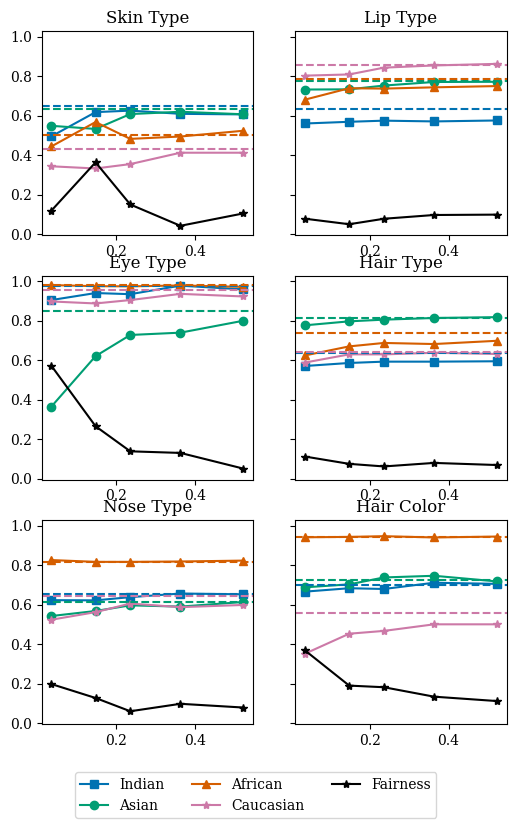

In [102]:
plot_races_and_fairness(temp, rates, results)

[array([0.73254086, 0.92124814, 0.85884101, 0.89450223, 0.92719168]), array([0.86554622, 0.8789916 , 0.9394958 , 0.93781513, 0.95966387]), array([0.83759124, 0.94160584, 0.95620438, 0.99270073, 0.97627737]), array([0.74065421, 0.74065421, 0.89953271, 0.9088785 , 0.96261682])]
[array([0.95874263, 0.93123772, 0.97053045, 0.97937132, 0.99607073]), array([0.33625, 0.75375, 0.81375, 0.86375, 0.935  ]), array([1.00280636, 0.9878391 , 0.99251637, 0.99906455, 1.00093545]), array([0.96931217, 0.90687831, 0.95767196, 0.96507937, 0.98412698])]
[array([0.92930781, 0.9808542 , 1.00441826, 0.97349043, 1.        ]), array([0.87737478, 0.89291883, 0.95682211, 0.98272884, 0.99654577]), array([1.00559284, 0.99105145, 0.99328859, 1.0033557 , 1.00223714]), array([0.80907668, 0.85289515, 0.9170579 , 0.94209703, 0.94366197])]
[array([0.87708649, 0.87253414, 0.88467375, 0.89074355, 0.93323217]), array([0.94642857, 0.97115385, 0.99450549, 0.96978022, 0.9532967 ]), array([0.84678363, 0.88888889, 0.9251462 , 0.

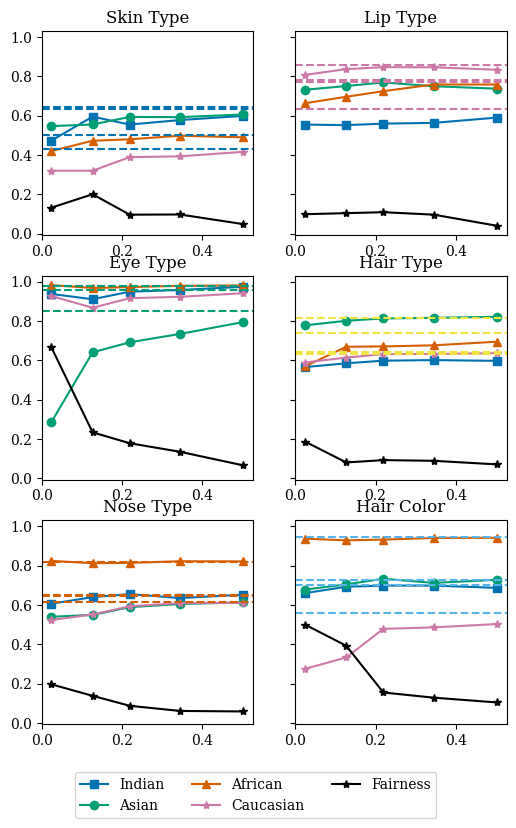

In [96]:
plot_races_and_fairness(ff_temp, ff_rates, ff_results)

In [89]:
def plot_races_and_fairness_single(temp, rates, results):
    categories = ["eye_type"]
    fig, axes = plt.subplots(len(categories), figsize=(3.3, 3.3), sharey=True)
    
    colors = ['b', 'y', 'g', 'r']
    axes.set_title("Accuracy vs Rate (by Group)")
    for i, cat in enumerate(categories):
        zz = []

        for j, race in enumerate(races):
            axes.plot(rates, temp[cat][race], marker=race_markers[j], color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j], label=race)

            zz.append(temp[cat][race])
        axes.plot(rates, np.array(zz).max(0) - np.array(zz).min(0), marker="d", linestyle = "dashdot" , color = plt.rcParams['axes.prop_cycle'].by_key()['color'][5], label="bias")
        #print(np.array(zz).max(0) - np.array(zz).min(0))

    for j, race in enumerate(races):
        for i, cat in enumerate(categories):
            axes.axhline(results[race][cat], linestyle="--", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j])
    axes.legend(bbox_to_anchor=(1.6, 0.7))
    axes.set_xlabel("bpp")
    axes.set_ylabel("Accuracy")
    plt.show()


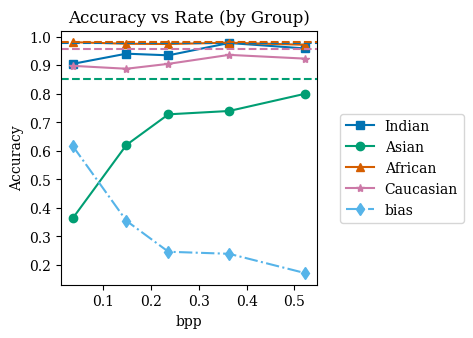

In [90]:
plot_races_and_fairness_single(temp, rates, results)

### 3.3

In [76]:
def all_fairness(temp, rates):
    fig, axes = plt.subplots(1, figsize=(3.3, 3.3), sharey=True)

    #colors = ['b', 'y', 'g', 'r', "darkviolet", "slategrey"]
    markers = ['s', 'o', '^', '*', "v", "h"]

    axes.set_title("Fairness")
    
    for i, cat in enumerate(categories):
        zz = []
        for j, race in enumerate(races):
            #axes[i].plot(rates, temp[cat][race], marker=race_markers[j], color = colors[j], label=race)
            zz.append(temp[cat][race])
        axes.plot(rates, np.array(zz).max(0) - np.array(zz).min(0), marker=markers[i], label=cat)
    axes.legend(bbox_to_anchor=(1.05, 0.7))
    axes.set_xlabel("bpp")
    axes.set_ylabel("bias")

    #for j, race in enumerate(races):
    #    for i, cat in enumerate(categories):
    #        axes[i].axhline(results[race][cat], linestyle="--", color=colors[j])
    
    plt.show()

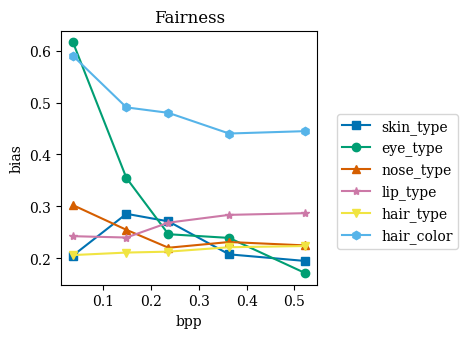

In [77]:
all_fairness(temp, rates)

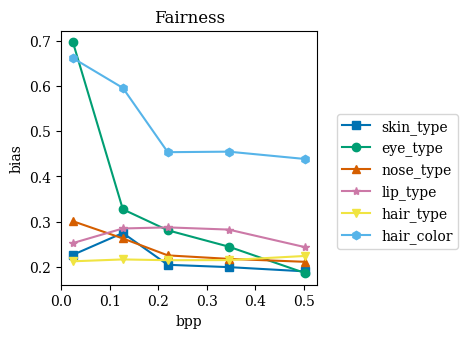

In [78]:
all_fairness(ff_temp, ff_rates)

In [79]:
def plot_fairness_comparison(temp, ff_temp, rates):
    categories = ["skin_type", "eye_type", "hair_color"]
    fig, axes = plt.subplots(1, figsize=(3.3, 3.3), sharey=True)
    markers = ['s', 'o', '^', '*', "v", "D"]

    axes.set_title("FairFace/celebA Comparison")
    
    for i, cat in enumerate(categories):
        zz = []
        yy = []
        for j, race in enumerate(races):
            #axes[i].plot(rates, temp[cat][race], marker=race_markers[j], color = colors[j], label=race)
            zz.append(temp[cat][race])
            yy.append(ff_temp[cat][race])
        axes.plot(rates, np.array(zz).max(0) - np.array(zz).min(0), marker=markers[i],  linestyle = "-", label=f"{cat} (celebA)", color=plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
        axes.plot(rates, np.array(yy).max(0) - np.array(yy).min(0), marker=markers[i], linestyle = "--", label=f"{cat} (Fairface)", color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i])
    axes.legend(bbox_to_anchor=(1.05, 0.7))
    axes.set_xlabel("bpp")
    axes.set_ylabel("bias")
        #print(np.array(zz).max(0) - np.array(zz).min(0))
    
        
    #for i, cat in enumerate(categories):
       # max_acc = 0
       # min_acc = 1
       # for j, race in enumerate(races):
       #     value = results[race][cat]
       #     if value > max_acc:
                #max_acc = value
       #     if value < min_acc:
                #min_acc = value
        #axes[i].axhline(max_acc - min_acc, linestyle="--", color=colors[j])
    
    plt.show()

In [80]:
def compute_fairness(temp, ff_temp): 
    model_fairness = {}
    model_fairness["celebA"] = {}
    model_fairness["fairface"] = {}
    for i, cat in enumerate(categories):
        zz = []
        yy = []
        for j, race in enumerate(races):
            zz.append(temp[cat][race])
            yy.append(ff_temp[cat][race])
        model_fairness["celebA"][cat] = (np.array(zz).max(0) - np.array(zz).min(0)).tolist()
        model_fairness["fairface"][cat] = (np.array(yy).max(0) - np.array(yy).min(0)).tolist()
    return model_fairness
    

In [81]:
#model_list = ["hyperprior", "qres17m", "cheng2020-attn", "mbt2018", "qarv"]

#all_fairness = {}

In [82]:
#for model in model_list:
#    temp, rates = generate_results(model=model)
#    ff_temp, ff_rates = generate_results("fairface", model=model)
#    all_fairness[model] = compute_fairness(temp, ff_temp)
#all_fairness

In [83]:
### Dump Fairness value to json

#import json
#with open('sep_fairness.json', 'w') as fp:
#    json.dump(all_fairness, fp)

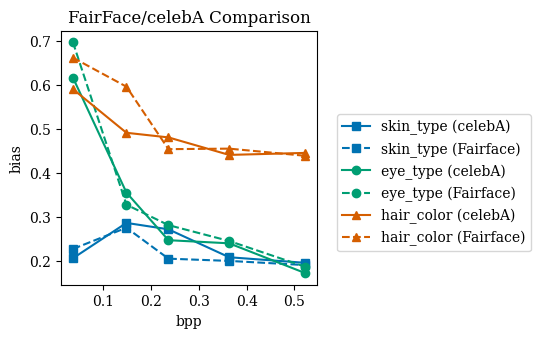

In [84]:
plot_fairness_comparison(temp, ff_temp, rates)